In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np
import os

from pmd_beamphysics import single_particle

# Quad Params

In [2]:
# calculate gamma*beta
c = 299792458
mec2 = 0.51099895000e6 # eV
Etot = 6e6 #eV
gamma = Etot/mec2
GB = np.sqrt(gamma**2 -1)

p = GB*mec2/1e6  # [MeV/c]

grad = 0.00714  # [T/m]
length =  0.21  # [m]
gap = 0.0254    # [1"] 

# Quad Profile w/Fringe 

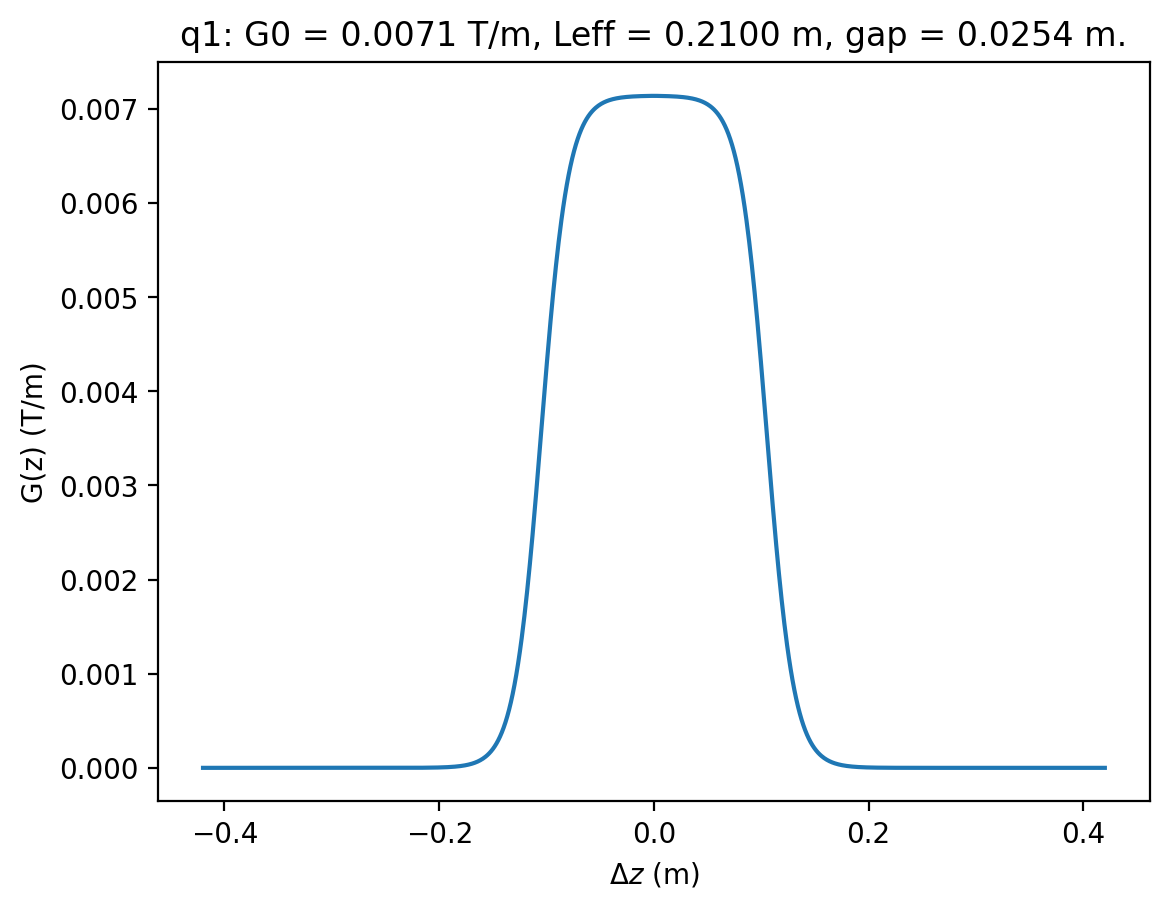

In [3]:
from gpt.lattice import Lattice
from gpt.bstatic import Quadrupole

lat = Lattice('quad test')
lat.add(Quadrupole('q1', grad, length, gap=0.0254), ds=0.25, element_origin='center')
lat['q1'].plot(title=True);

# Kick predictions
The kick in the x and y directions for an offset particle can be approximated as $\Delta \theta_x \approx (eG/p)L_{\text{eff}}\cdot\Delta x$ and $\Delta \theta_y \approx -(eG/p)L_{\text{eff}}\cdot\Delta y$

In [4]:
x_off = 1e-3 # 1 mm
y_off = 1e-3 # 1 mm

print('Predicted H-kick:', +lat['q1']._G*c/(p*1e6)*lat['q1'].Leff*x_off)
print('Predicted V-kick:', -lat['q1']._G*c/(p*1e6)*lat['q1'].Leff*y_off)

Predicted H-kick: 7.519365890270874e-05
Predicted V-kick: -7.519365890270874e-05


In [5]:
from gpt import GPT

lat.write_gpt_lines(output_file='gpt.temp.in')

G = GPT(input_file='gpt.temp.in')
G.set_variables({'space_charge':0, 'xacc':12, 'GBacc':12, 'Ntout':100})

{'space_charge': True, 'xacc': True, 'GBacc': True, 'Ntout': True}

In [6]:
Gx = G.copy()
particles_x = Gx.track1(x0=x_off, pz0=p*1e6)
Gx.run()

Gy = G.copy()
particles_y = Gy.track1(y0=y_off, pz0=p*1e6)
Gy.run()

print('Computed H-kick:', particles_x.tout[-1]['mean_px']/particles_x.tout[-1]['mean_pz'])
print('Computed V-kick:', particles_y.tout[-1]['mean_py']/particles_y.tout[-1]['mean_pz'])

Computed H-kick: 7.540199045843224e-05
Computed V-kick: -7.498020932977606e-05


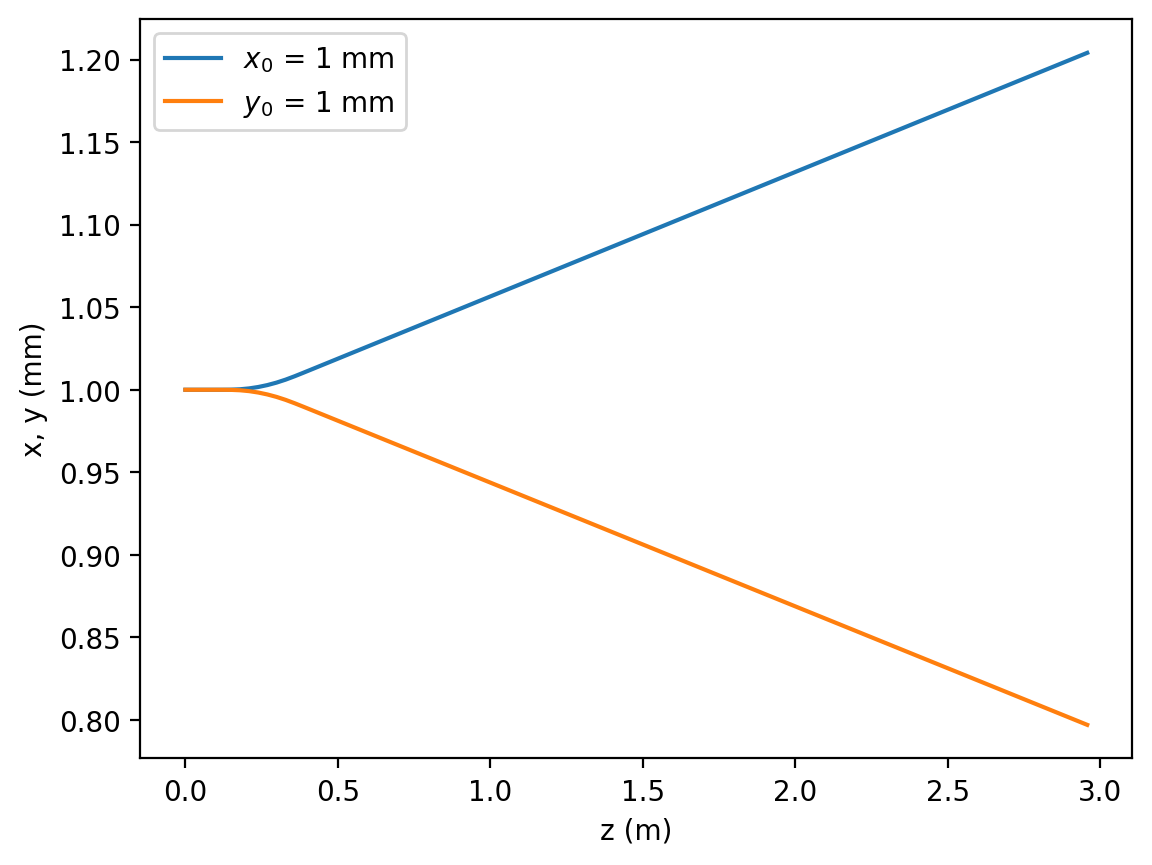

In [7]:
plt.plot(Gx.tout_stat('mean_z'), Gx.tout_stat('mean_x')*1000, Gy.tout_stat('mean_z'), Gy.tout_stat('mean_y')*1000);
plt.xlabel('z (m)');
plt.ylabel('x, y (mm)');
plt.legend(['$x_0$ = 1 mm', '$y_0$ = 1 mm']);

# Quad fringe check
Here the consistency of the internal quad fringe field formulas is checked and compared to the results from the quadf custrom GPT element.  First the derivative of the gradient is integrate and compared to the gradient.

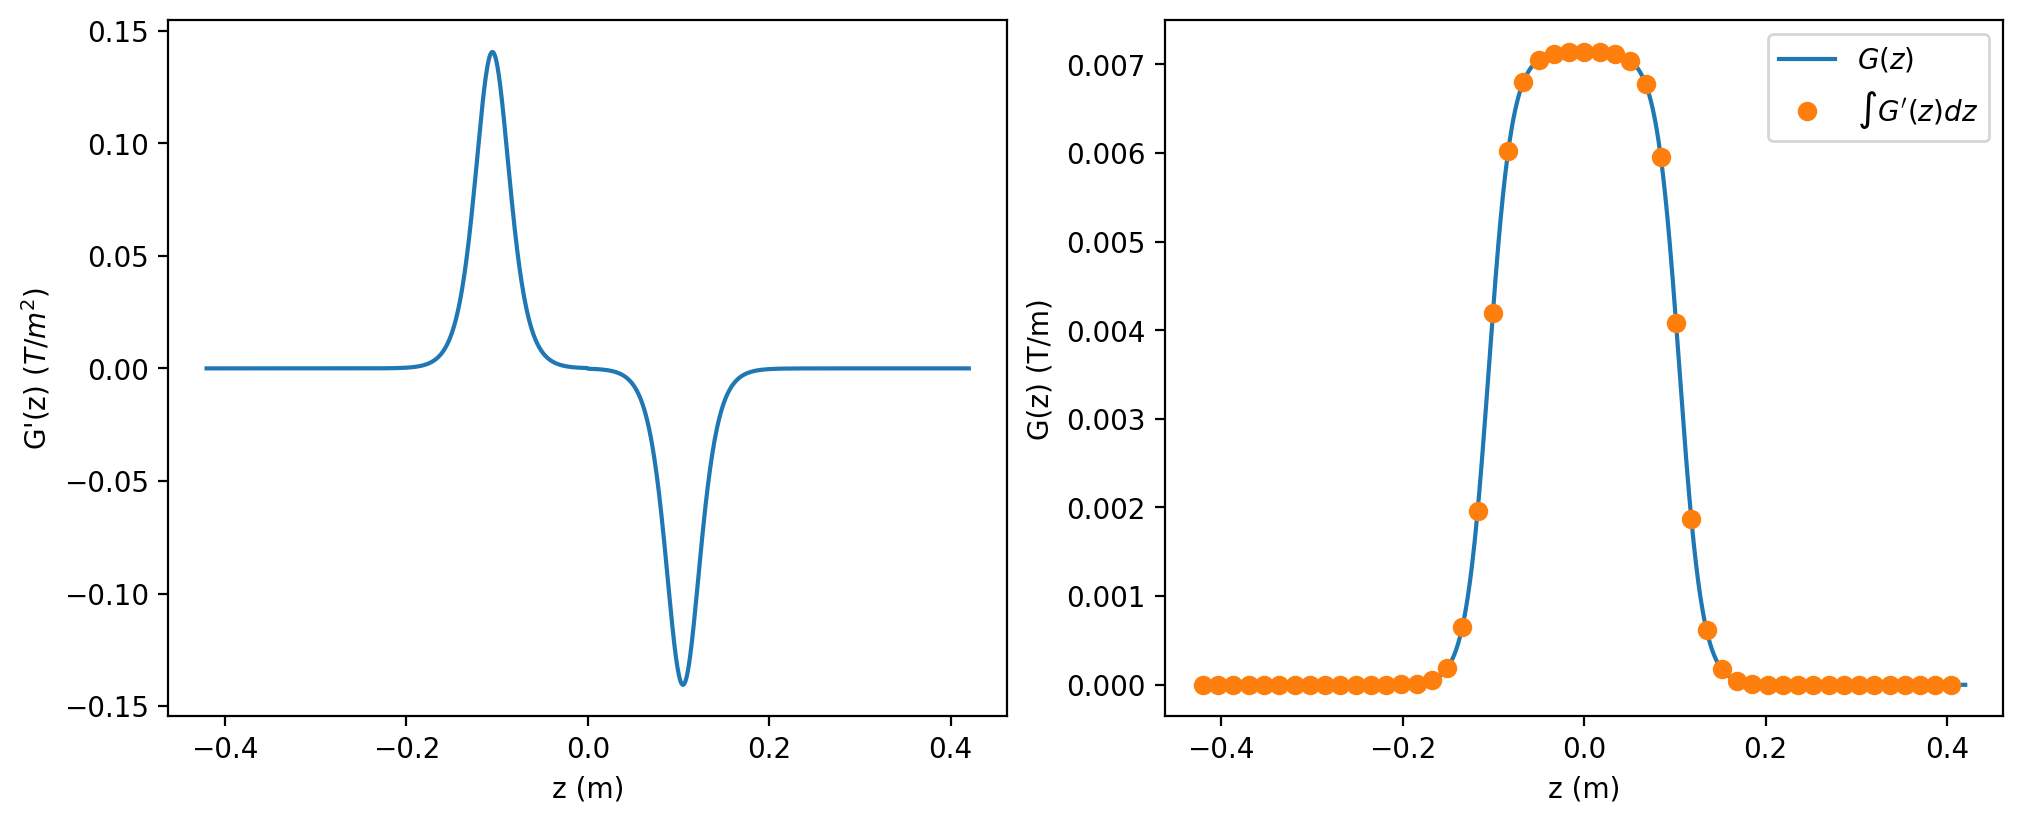

In [8]:
from scipy.integrate import  cumulative_trapezoid as cumtrapz

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True, figsize=[10,4])
lat['q1'].plot_dGdz(ax=ax[0])
lat.write_gpt_lines(output_file='gpt.temp.in')
grad = cumtrapz(lat['q1'].dGdz, lat['q1'].z, initial=0)
ax[1].plot(lat['q1'].z, lat['q1'].G, lat['q1'].z[::20], grad[::20], 'o');
ax[1].legend([r'$G(z)$', r"$\int G'(z) dz$"]);
ax[1].set_xlabel('z (m)')
ax[1].set_ylabel('G(z) (T/m)');

Similarly, the second derivative is computed and integrated and compared to the first:

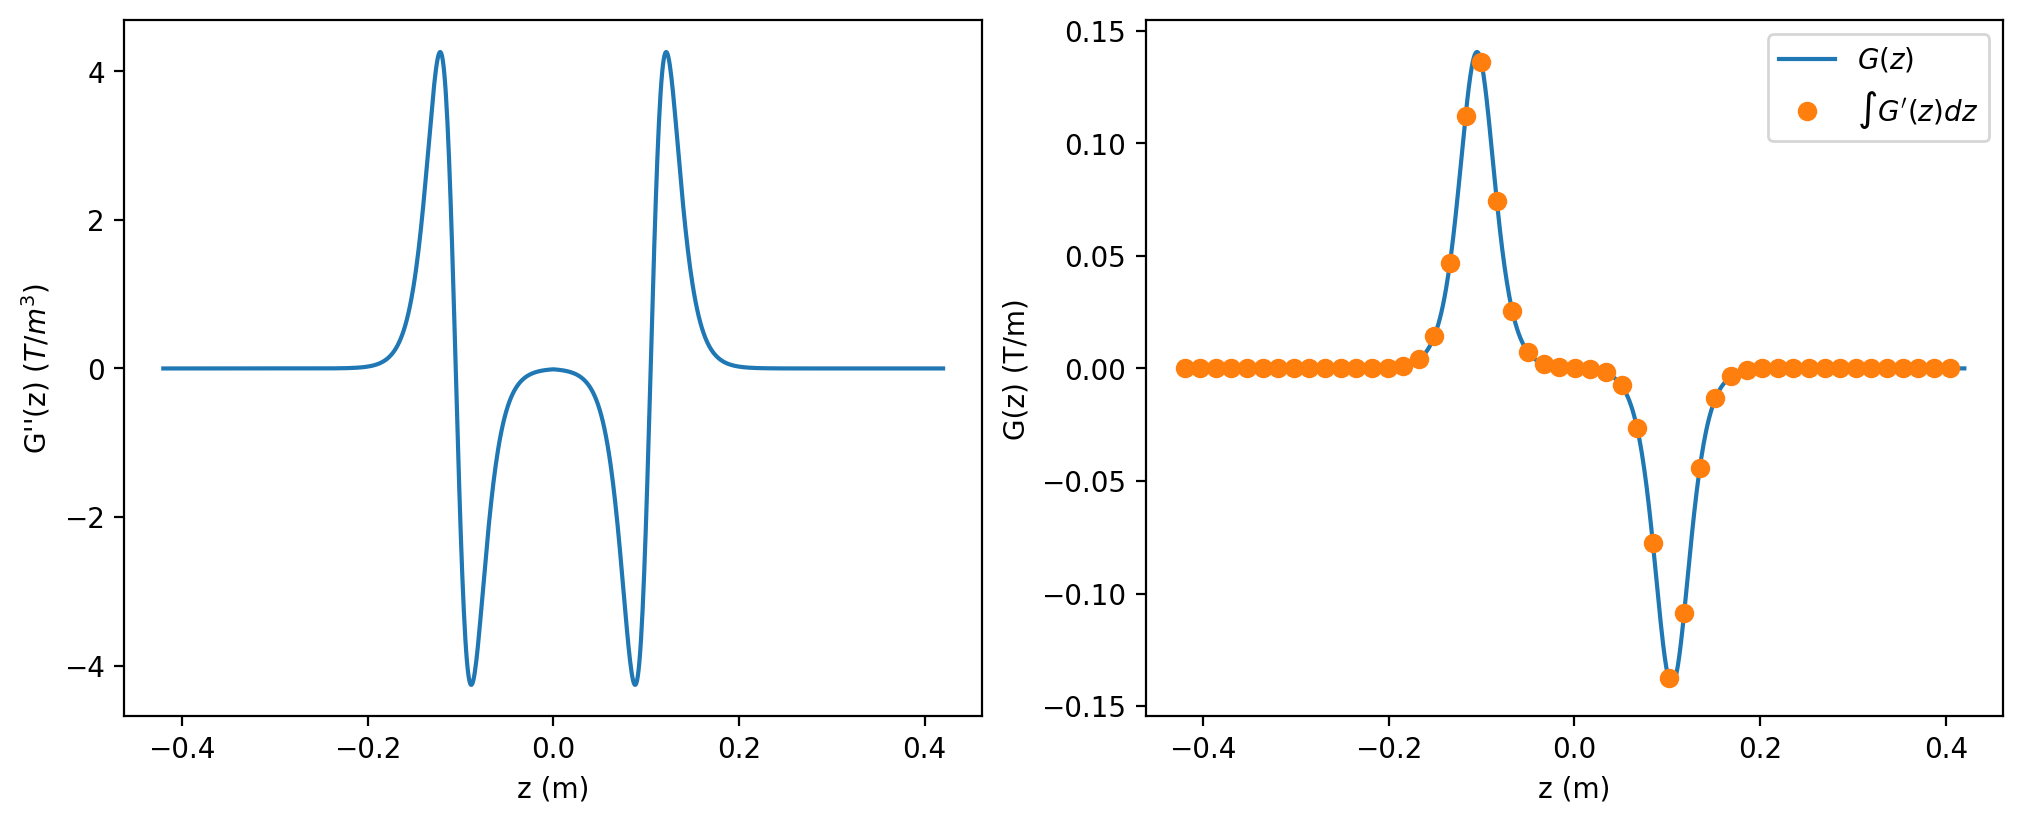

In [9]:
fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True, figsize=[10,4])
lat['q1'].plot_d2Gdz2(ax=ax[0])

grad = cumtrapz(lat['q1'].d2Gdz2, lat['q1'].z, initial=0)
ax[1].plot(lat['q1'].z, lat['q1'].dGdz, lat['q1'].z[::20], grad[::20], 'o');
ax[1].legend([r'$G(z)$', r"$\int G'(z) dz$"]);
ax[1].set_xlabel('z (m)')
ax[1].set_ylabel('G(z) (T/m)');

In [10]:
G = GPT('gpt.temp.in', load_all_gdf_data=True)
G.set_variables({'ZSTOP':0.5, 'Ntout':500})

{'ZSTOP': True, 'Ntout': True}

In [11]:
P = single_particle(pz=1e6) + single_particle(pz=1e6, x=1e-3)

In [12]:
G.initial_particles = P
G.run()

In [13]:
G0 = [(F['fBy'][1]-F['fBy'][0])/(G.tout[ii].x[1] - G.tout[ii].x[0]) for ii, F in enumerate(G.tout_fields)]

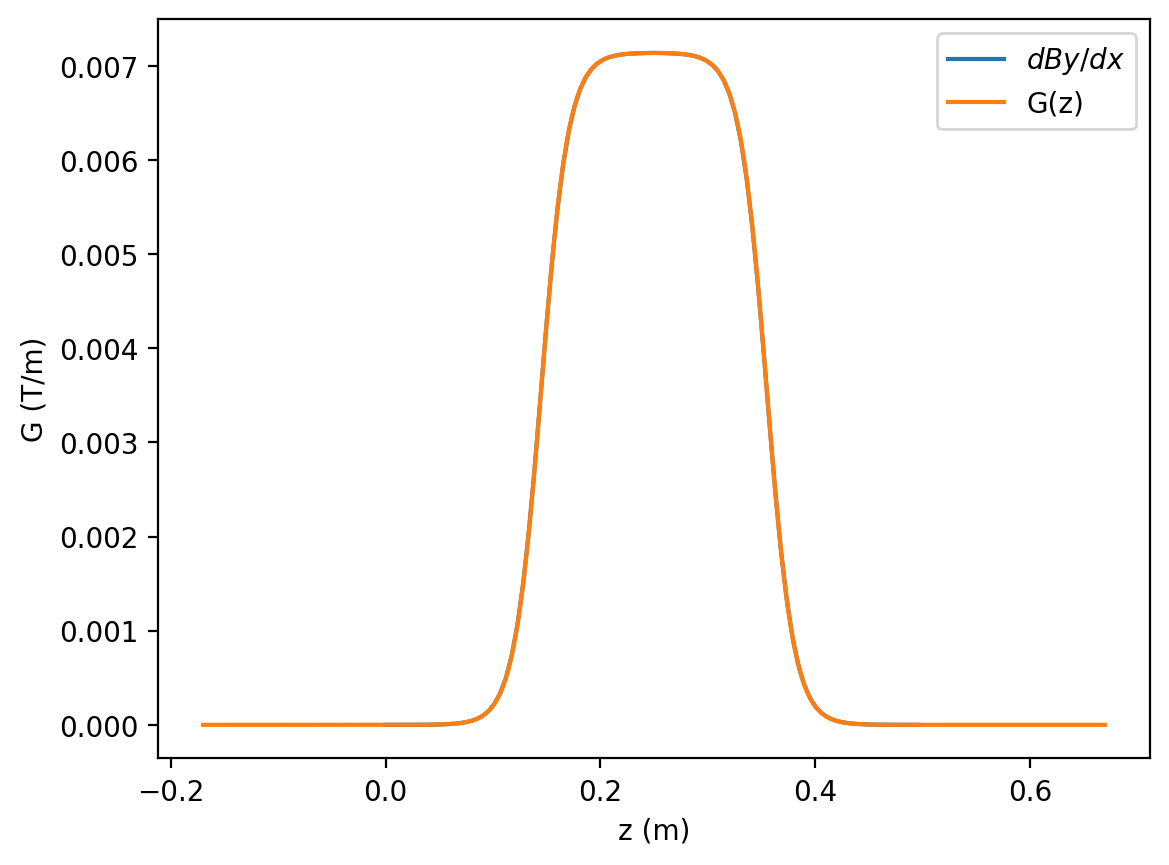

In [14]:
plt.plot(G.tout_stat('mean_z'), G0);

s0 = 0.5*(lat['q1'].s_beg + lat['q1'].s_end)

plt.plot(s0 + lat['q1'].z, lat['q1'].grad());
plt.legend(['$dBy/dx$', 'G(z)']);
plt.xlabel('z (m)');
plt.ylabel('G (T/m)');

In [15]:
if os.path.exists('gpt.temp.in'):
    os.remove('gpt.temp.in')